# Import Library

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress info and warning messages

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import (
    Sequential,
    Model
)
from tensorflow.keras.layers import (
    Dense,
    LeakyReLU,
    Dropout,
    BatchNormalization,
    Reshape,
    Flatten,
    Input, 
    Embedding, 
    multiply,
    Concatenate
)
from tensorflow.keras.optimizers import Adam

# 1. Preprocessing Dataset

In [3]:
iot_data = pd.read_csv('../Dataset/iot23_combinednew.csv')

iot_data

,Unnamed: 0,duration,orig_bytes,resp_bytes,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,label,...,proto_udp,conn_state_OTH,conn_state_REJ,conn_state_RSTO,conn_state_RSTOS0,conn_state_RSTR,conn_state_S0,conn_state_S1,conn_state_S3,conn_state_SF
0,0,5.005154,78.0,0.0,0.0,2.0,134.0,0.0,0.0,Benign,...,1,0,0,0,0,0,1,0,0,0
1,1,0.002246,90.0,90.0,0.0,2.0,146.0,2.0,146.0,Benign,...,1,0,0,0,0,0,0,0,0,1
2,2,5.005157,78.0,0.0,0.0,2.0,134.0,0.0,0.0,Benign,...,1,0,0,0,0,0,1,0,0,0
3,3,0.001999,90.0,90.0,0.0,2.0,146.0,2.0,146.0,Benign,...,1,0,0,0,0,0,0,0,0,1
4,4,5.001404,78.0,0.0,0.0,2.0,134.0,0.0,0.0,Benign,...,1,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126342,99994,NaN,NaN,NaN,0.0,6.0,360.0,0.0,0.0,PartOfAHorizontalPortScan,...,0,0,0,0,0,0,1,0,0,0
126343,99995,NaN,NaN,NaN,0.0,6.0,360.0,0.0,0.0,PartOfAHorizontalPortScan,...,0,0,0,0,0,0,1,0,0,0
126344,99996,NaN,NaN,NaN,0.0,6.0,360.0,0.0,0.0,PartOfAHorizontalPortScan,...,0,0,0,0,0,0,1,0,0,0
126345,99997,NaN,NaN,NaN,0.0,6.0,360.0,0.0,0.0,PartOfAHorizontalPortScan,...,0,0,0,0,0,0,1,0,0,0


In [4]:
# Menghapus kolom 'Unnamed: 0'
iot_data = iot_data.drop(columns=['Unnamed: 0'])

iot_data

,duration,orig_bytes,resp_bytes,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,label,proto_icmp,...,proto_udp,conn_state_OTH,conn_state_REJ,conn_state_RSTO,conn_state_RSTOS0,conn_state_RSTR,conn_state_S0,conn_state_S1,conn_state_S3,conn_state_SF
0,5.005154,78.0,0.0,0.0,2.0,134.0,0.0,0.0,Benign,0,...,1,0,0,0,0,0,1,0,0,0
1,0.002246,90.0,90.0,0.0,2.0,146.0,2.0,146.0,Benign,0,...,1,0,0,0,0,0,0,0,0,1
2,5.005157,78.0,0.0,0.0,2.0,134.0,0.0,0.0,Benign,0,...,1,0,0,0,0,0,1,0,0,0
3,0.001999,90.0,90.0,0.0,2.0,146.0,2.0,146.0,Benign,0,...,1,0,0,0,0,0,0,0,0,1
4,5.001404,78.0,0.0,0.0,2.0,134.0,0.0,0.0,Benign,0,...,1,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126342,NaN,NaN,NaN,0.0,6.0,360.0,0.0,0.0,PartOfAHorizontalPortScan,0,...,0,0,0,0,0,0,1,0,0,0
126343,NaN,NaN,NaN,0.0,6.0,360.0,0.0,0.0,PartOfAHorizontalPortScan,0,...,0,0,0,0,0,0,1,0,0,0
126344,NaN,NaN,NaN,0.0,6.0,360.0,0.0,0.0,PartOfAHorizontalPortScan,0,...,0,0,0,0,0,0,1,0,0,0
126345,NaN,NaN,NaN,0.0,6.0,360.0,0.0,0.0,PartOfAHorizontalPortScan,0,...,0,0,0,0,0,0,1,0,0,0


In [5]:
# Menampilkan kolom
print("Kolom:", iot_data.columns.tolist())

Kolom: ['duration', 'orig_bytes', 'resp_bytes', 'missed_bytes', 'orig_pkts', 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes', 'label', 'proto_icmp', 'proto_tcp', 'proto_udp', 'conn_state_OTH', 'conn_state_REJ', 'conn_state_RSTO', 'conn_state_RSTOS0', 'conn_state_RSTR', 'conn_state_S0', 'conn_state_S1', 'conn_state_S3', 'conn_state_SF']


In [6]:
# tampilkan ada label apa aja dari kolom label
unique_labels = iot_data["label"].unique()
print(unique_labels)

['Benign' 'C&C-Torii' 'C&C' 'PartOfAHorizontalPortScan' 'DDoS'
 'C&C-HeartBeat-FileDownload' 'Attack']


In [7]:
iot_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126347 entries, 0 to 126346
Data columns (total 21 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   duration           26348 non-null   float64
 1   orig_bytes         26348 non-null   float64
 2   resp_bytes         26348 non-null   float64
 3   missed_bytes       126347 non-null  float64
 4   orig_pkts          126347 non-null  float64
 5   orig_ip_bytes      126347 non-null  float64
 6   resp_pkts          126347 non-null  float64
 7   resp_ip_bytes      126347 non-null  float64
 8   label              126347 non-null  object 
 9   proto_icmp         126347 non-null  int64  
 10  proto_tcp          126347 non-null  int64  
 11  proto_udp          126347 non-null  int64  
 12  conn_state_OTH     126347 non-null  int64  
 13  conn_state_REJ     126347 non-null  int64  
 14  conn_state_RSTO    126347 non-null  int64  
 15  conn_state_RSTOS0  126347 non-null  int64  
 16  co

In [8]:
iot_data.isna().sum()

duration             99999
orig_bytes           99999
resp_bytes           99999
missed_bytes             0
orig_pkts                0
orig_ip_bytes            0
resp_pkts                0
resp_ip_bytes            0
label                    0
proto_icmp               0
proto_tcp                0
proto_udp                0
conn_state_OTH           0
conn_state_REJ           0
conn_state_RSTO          0
conn_state_RSTOS0        0
conn_state_RSTR          0
conn_state_S0            0
conn_state_S1            0
conn_state_S3            0
conn_state_SF            0
dtype: int64

In [9]:
iot_data.nunique()

duration             5744
orig_bytes             39
resp_bytes             53
missed_bytes            6
orig_pkts              67
orig_ip_bytes         142
resp_pkts              44
resp_ip_bytes          92
label                   7
proto_icmp              2
proto_tcp               2
proto_udp               2
conn_state_OTH          2
conn_state_REJ          2
conn_state_RSTO         2
conn_state_RSTOS0       2
conn_state_RSTR         2
conn_state_S0           2
conn_state_S1           2
conn_state_S3           2
conn_state_SF           2
dtype: int64

In [10]:
iot_data[["duration", "orig_bytes", "resp_bytes"]] = iot_data[
    ["duration", "orig_bytes", "resp_bytes"]
].fillna(0)

In [11]:
iot_data.isna().sum()

duration             0
orig_bytes           0
resp_bytes           0
missed_bytes         0
orig_pkts            0
orig_ip_bytes        0
resp_pkts            0
resp_ip_bytes        0
label                0
proto_icmp           0
proto_tcp            0
proto_udp            0
conn_state_OTH       0
conn_state_REJ       0
conn_state_RSTO      0
conn_state_RSTOS0    0
conn_state_RSTR      0
conn_state_S0        0
conn_state_S1        0
conn_state_S3        0
conn_state_SF        0
dtype: int64

In [12]:
iot_data.tail(5)

,duration,orig_bytes,resp_bytes,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,label,proto_icmp,...,proto_udp,conn_state_OTH,conn_state_REJ,conn_state_RSTO,conn_state_RSTOS0,conn_state_RSTR,conn_state_S0,conn_state_S1,conn_state_S3,conn_state_SF
126342,0.0,0.0,0.0,0.0,6.0,360.0,0.0,0.0,PartOfAHorizontalPortScan,0,...,0,0,0,0,0,0,1,0,0,0
126343,0.0,0.0,0.0,0.0,6.0,360.0,0.0,0.0,PartOfAHorizontalPortScan,0,...,0,0,0,0,0,0,1,0,0,0
126344,0.0,0.0,0.0,0.0,6.0,360.0,0.0,0.0,PartOfAHorizontalPortScan,0,...,0,0,0,0,0,0,1,0,0,0
126345,0.0,0.0,0.0,0.0,6.0,360.0,0.0,0.0,PartOfAHorizontalPortScan,0,...,0,0,0,0,0,0,1,0,0,0
126346,0.0,0.0,0.0,0.0,6.0,360.0,0.0,0.0,PartOfAHorizontalPortScan,0,...,0,0,0,0,0,0,1,0,0,0


In [13]:
# Melihat distribusi missing values di antara label
print(iot_data[iot_data["duration"].isna()]["label"].value_counts())

Series([], Name: label, dtype: int64)


PartOfAHorizontalPortScan     99892
DDoS                          14394
C&C                            6706
Benign                         5230
Attack                          101
C&C-Torii                        16
C&C-HeartBeat-FileDownload        8
Name: label, dtype: int64


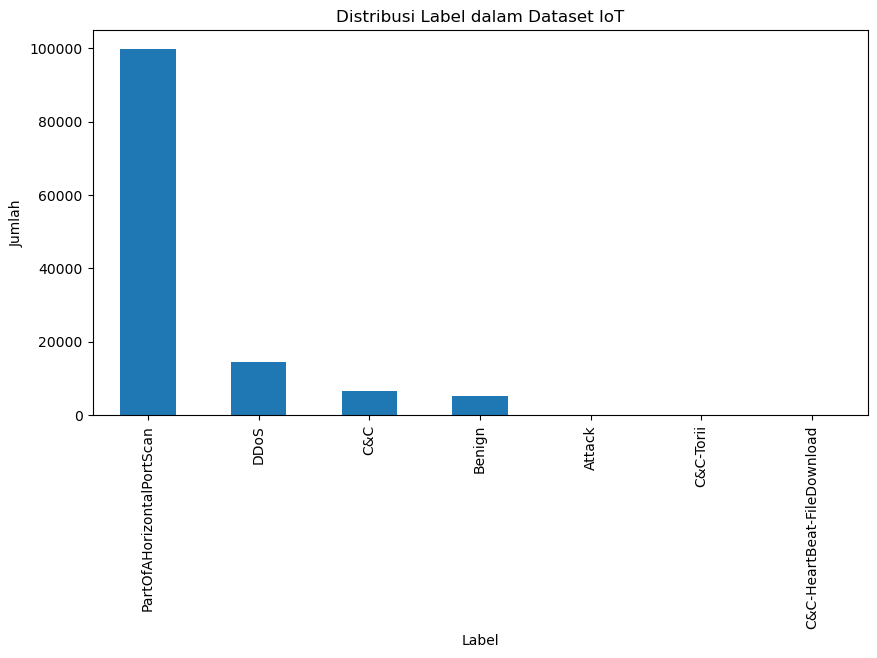

In [14]:
import matplotlib.pyplot as plt

label_counts = iot_data["label"].value_counts()
print(label_counts)

# Visualisasi distribusi label
plt.figure(figsize=(10, 5))
label_counts.plot(kind="bar")
plt.title("Distribusi Label dalam Dataset IoT")
plt.xlabel("Label")
plt.ylabel("Jumlah")
plt.show()

### Encode Label to Numeric and Normalisasi Fitur

In [15]:
label_encoder = LabelEncoder()

iot_data['label'] = label_encoder.fit_transform(iot_data['label'])

X = iot_data.drop('label', axis=1)
y = iot_data['label']


In [16]:
X

,duration,orig_bytes,resp_bytes,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,proto_icmp,proto_tcp,proto_udp,conn_state_OTH,conn_state_REJ,conn_state_RSTO,conn_state_RSTOS0,conn_state_RSTR,conn_state_S0,conn_state_S1,conn_state_S3,conn_state_SF
0,5.005154,78.0,0.0,0.0,2.0,134.0,0.0,0.0,0,0,1,0,0,0,0,0,1,0,0,0
1,0.002246,90.0,90.0,0.0,2.0,146.0,2.0,146.0,0,0,1,0,0,0,0,0,0,0,0,1
2,5.005157,78.0,0.0,0.0,2.0,134.0,0.0,0.0,0,0,1,0,0,0,0,0,1,0,0,0
3,0.001999,90.0,90.0,0.0,2.0,146.0,2.0,146.0,0,0,1,0,0,0,0,0,0,0,0,1
4,5.001404,78.0,0.0,0.0,2.0,134.0,0.0,0.0,0,0,1,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126342,0.000000,0.0,0.0,0.0,6.0,360.0,0.0,0.0,0,1,0,0,0,0,0,0,1,0,0,0
126343,0.000000,0.0,0.0,0.0,6.0,360.0,0.0,0.0,0,1,0,0,0,0,0,0,1,0,0,0
126344,0.000000,0.0,0.0,0.0,6.0,360.0,0.0,0.0,0,1,0,0,0,0,0,0,1,0,0,0
126345,0.000000,0.0,0.0,0.0,6.0,360.0,0.0,0.0,0,1,0,0,0,0,0,0,1,0,0,0


In [17]:
y

0         1
1         1
2         1
3         1
4         1
         ..
126342    6
126343    6
126344    6
126345    6
126346    6
Name: label, Length: 126347, dtype: int64

In [18]:
# Normalisasi fitur numerik
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Generator

In [20]:
# Set dimensions based on your dataset
input_dim = X_train.shape[1]  # number of features

# Define the Generator
generator = Sequential([
    Dense(64, input_dim=100),  # input is random noise
    LeakyReLU(0.2),
    BatchNormalization(momentum=0.8),
    Dense(128),
    LeakyReLU(0.2),
    BatchNormalization(momentum=0.8),
    Dense(256),
    LeakyReLU(0.2),
    Dense(input_dim, activation='tanh')  # output matches feature dimension
])

generator.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                6464      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64)                0         
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 128)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                        

# Discriminator

In [21]:
# Define the Discriminator
discriminator = Sequential([
    Dense(256, input_dim=input_dim),
    LeakyReLU(0.2),
    Dropout(0.3),
    Dense(128),
    LeakyReLU(0.2),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # binary output for real/fake
])

discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
discriminator.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 256)               5376      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 128)               32896     
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 128)               0         
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 1)                

# Combining Generator and Discriminator (GAN Model)

In [22]:
# Freeze discriminator weights when training the generator
discriminator.trainable = False

# GAN model
gan_input = Input(shape=(100,))
generated_data = generator(gan_input)
gan_output = discriminator(generated_data)

gan = Model(gan_input, gan_output)
gan.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy')
gan.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential (Sequential)     (None, 20)                53716     
                                                                 
 sequential_1 (Sequential)   (None, 1)                 38401     
                                                                 
Total params: 92,117
Trainable params: 53,332
Non-trainable params: 38,785
_________________________________________________________________


# Training the GAN

In [23]:
epochs = 10000
batch_size = 64
sample_interval = 1000  # interval to save generated samples for evaluation

In [24]:
import tensorflow as tf

for epoch in range(epochs):
    # Train Discriminator
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    real_data = X_train[idx]
    noise = np.random.normal(0, 1, (batch_size, 100))
    generated_data = generator.predict(noise)
    
    # Labels for real and fake data
    real_labels = np.ones((batch_size, 1))
    fake_labels = np.zeros((batch_size, 1))
    
    # Train discriminator
    d_loss_real = discriminator.train_on_batch(real_data, real_labels)
    d_loss_fake = discriminator.train_on_batch(generated_data, fake_labels)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    
    # Train Generator (where discriminator's weights are frozen)
    noise = np.random.normal(0, 1, (batch_size, 100))
    valid_labels = np.ones((batch_size, 1))  # misleading labels for GAN training
    g_loss = gan.train_on_batch(noise, valid_labels)
    
    # Logging the progress
    if epoch % sample_interval == 0:
        print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]}] [G loss: {g_loss}]")


2/2 [==============================] - 0s 3ms/step
0 [D loss: 0.7207913994789124, acc.: 35.9375] [G loss: 0.728911280632019]
2/2 [==============================] - 0s 2ms/step


2/2 [==============================] - 0s 2ms/step


2/2 [==============================] - 0s 2ms/step


2/2 [==============================] - 0s 2ms/step
1000 [D loss: 0.009796152357012033, acc.: 100.0] [G loss: 6.5101728439331055]
2/2 [==============================] - 0s 2ms/step


2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 2ms/step


2/2 [==============================] - 0s 2ms/step
2000 [D loss: 0.08411838658503257, acc.: 96.09375] [G loss: 5.817332744598389]
2/2 [==============================] - 0s 2ms/step


2/2 [==============================] - 0s 2ms/step


2/2 [==============================] - 0s 2ms/step


2/2 [==============================] - 0s 2ms/step
3000 [D loss: 0.014024061616510153, acc.: 100.0] [G loss: 7.478747367858887]
2/2 [==============================] - 0s 2ms/step


2/2 [==============================] - 0s 2ms/step


2/2 [==============================] - 0s 2ms/step


2/2 [==============================] - 0s 1ms/step
4000 [D loss: 0.37174129113554955, acc.: 87.5] [G loss: 3.480071544647217]
2/2 [==============================] - 0s 2ms/step


2/2 [==============================] - 0s 2ms/step


2/2 [==============================] - 0s 2ms/step


2/2 [==============================] - 0s 2ms/step
5000 [D loss: 0.04068666324019432, acc.: 99.21875] [G loss: 7.981919288635254]
2/2 [==============================] - 0s 2ms/step


2/2 [==============================] - 0s 2ms/step


2/2 [==============================] - 0s 2ms/step


2/2 [==============================] - 0s 2ms/step
6000 [D loss: 0.18734219297766685, acc.: 92.96875] [G loss: 3.9844892024993896]
2/2 [==============================] - 0s 2ms/step


2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 2ms/step
7000 [D loss: 0.10500871762633324, acc.: 98.4375] [G loss: 6.494694709777832]
2/2 [==============================] - 0s 2ms/step


2/2 [==============================] - 0s 2ms/step


2/2 [==============================] - 0s 2ms/step


2/2 [==============================] - 0s 2ms/step


2/2 [==============================] - 0s 2ms/step
8000 [D loss: 0.12130260095000267, acc.: 93.75] [G loss: 5.651239395141602]
2/2 [==============================] - 0s 2ms/step


2/2 [==============================] - 0s 2ms/step


2/2 [==============================] - 0s 2ms/step


2/2 [==============================] - 0s 2ms/step
9000 [D loss: 0.05362796410918236, acc.: 100.0] [G loss: 5.823705673217773]
2/2 [==============================] - 0s 2ms/step


2/2 [==============================] - 0s 2ms/step


2/2 [==============================] - 0s 2ms/step


2/2 [==============================] - 0s 2ms/step


In [25]:
# Generate synthetic samples
noise = np.random.normal(0, 1, (5000, 100))  # generating 5000 synthetic samples
synthetic_data = generator.predict(noise)

# Add synthetic labels (assuming binary classification, e.g., label=1 for synthetic)
synthetic_labels = np.ones((5000,))  # or a balanced mix if you prefer

# Combine with real data
X_augmented = np.vstack((X_train, synthetic_data))
y_augmented = np.hstack((y_train, synthetic_labels))

# Train classifier on augmented data (e.g., RandomForest, SVM, etc.)
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier()
classifier.fit(X_augmented, y_augmented)

# Evaluate on test set
y_pred = classifier.predict(X_test)
from sklearn.metrics import accuracy_score
print("Classifier Accuracy on Test Set:", accuracy_score(y_test, y_pred))


157/157 [==============================] - 0s 648us/step
Classifier Accuracy on Test Set: 0.9983115683946708


In [26]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and train the model
classifier = RandomForestClassifier(random_state=42)
classifier.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [28]:
from sklearn.metrics import classification_report, fbeta_score

# Predictions
y_pred = classifier.predict(X_test)

# Classification report for precision, recall, and F1 (macro and weighted)
report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
print("Classification Report:", report)

# Calculate F2 Score (macro and weighted)
f2_macro = fbeta_score(y_test, y_pred, beta=2, average='macro', zero_division=0)
f2_weighted = fbeta_score(y_test, y_pred, beta=2, average='weighted', zero_division=0)

print(f"Macro F2 Score: {f2_macro}")
print(f"Weighted F2 Score: {f2_weighted}")


Classification Report: {'0': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 30}, '1': {'precision': 1.0, 'recall': 0.980453972257251, 'f1-score': 0.9901305316778096, 'support': 1586}, '2': {'precision': 0.9886307464162135, 'recall': 1.0, 'f1-score': 0.9942828734775044, 'support': 2000}, '3': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 2}, '4': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 3}, '5': {'precision': 0.9907235621521335, 'recall': 0.9997659723847414, 'f1-score': 0.9952242283051834, 'support': 4273}, '6': {'precision': 0.999966647767068, 'recall': 0.9990336876478625, 'f1-score': 0.9994999499949995, 'support': 30011}, 'accuracy': 0.9983115683946708, 'macro avg': {'precision': 0.8541887080479164, 'recall': 0.854179090327122, 'f1-score': 0.8541625119222137, 'support': 37905}, 'weighted avg': {'precision': 0.9982488415788411, 'recall': 0.9983115683946708, 'f1-score': 0.998271966681018, 'support': 37905}}
Macro F2 Score: 0.8541673625

In [29]:
from collections import Counter
print("Class distribution in y_test:", Counter(y_test))
print("Class distribution in y_pred:", Counter(y_pred))


Class distribution in y_test: Counter({6: 30011, 5: 4273, 2: 2000, 1: 1586, 0: 30, 4: 3, 3: 2})
Class distribution in y_pred: Counter({6: 29983, 5: 4312, 2: 2023, 1: 1555, 0: 30, 3: 2})
